In [1]:
import numpy as np
from numpy import cos, sin, pi, sqrt, arccos, log
import matplotlib.pyplot as plt

In [2]:
def simplified_fun(x, y, N):
    #  the boundary is divided into N semgements, 
    #  each segment  end points xp,yp and xm, ym are elements of arrays 
    #  (xp[i],yp[i])__________(barx[i], bary[i])____________(xm[i], ym[i]) 
    #  where barx and bary are coordinates of midpoints
    xp = x[1:]
    yp = y[1:]
    xm = x[:-1]
    ym = y[:-1]
    barx = 0.5 * (xp + xm)
    bary = 0.5 * (yp + ym)
    
    ds = sqrt((xp - xm) ** 2 + (yp - ym) ** 2)
    # compute direction vectors
    directions = np.column_stack([xp - xm, yp - ym])
    # Rotate directions by 90 degrees to obtain normal vectors
    normals = np.column_stack([-directions[:, 1], directions[:, 0]])
    # normalize normal vectors
    norms = np.linalg.norm(normals, axis=1)
    normals_normalized = normals / norms[:, np.newaxis]
    nn1 = normals_normalized[:, 0]
    nn2 = normals_normalized[:, 1]
    nn6 = barx*nn2 - bary*nn1

    hh1 = np.zeros(N)
    hh2 = np.zeros(N)
    hh6 = np.zeros(N)
    dtheta = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            a1 = xm[j] - barx[i]
            a2 = ym[j] - bary[i]
            b1 = xp[j] - barx[i]
            b2 = yp[j] - bary[i]

            # we constrain the argument between -1 and 1 to avoid numerical issues due to round-off errors
            ttemp = np.clip((a1 * b1 + a2 * b2) / sqrt( (a1**2 + a2**2) * (b1**2 + b2**2)), -1, 1)
            dtheta[i, j] = -arccos(ttemp)
            if j - i == 0:
                dtheta[i, j] = -pi # for m=n
            x1g = 0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y1g = 0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            x2g = -0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y2g = -0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            hh0 = log((x1g - barx[i])**2 + (y1g - bary[i])**2)
            hh0 = hh0 + log((x2g - barx[i])**2 + (y2g - bary[i])**2)
            hh0 = hh0 * 0.5
            hh1[i] += hh0 * nn1[j] * ds[j] / 2
            hh2[i] += hh0 * nn2[j] * ds[j] / 2
            hh6[i] += hh0 * nn6[j] * ds[j] / 2

    # the linear system is solved using a standard numpy linear algebra solver
    pdcr1 = (np.linalg.solve(dtheta, hh1))
    pdcr2 = (np.linalg.solve(dtheta, hh2))
    pdcr6 = (np.linalg.solve(dtheta, hh6))

    # finally we compute the added mass coefficents
    a11 = np.sum(pdcr1 * nn1 * ds)
    a22 = np.sum(pdcr2 * nn2 * ds)
    a66 = np.sum(pdcr6 * nn6 * ds)
   
    return pdcr1, [a11, a22, a66]

In [3]:
def solve(figure_type, a, b, number_of_elems):
    theta = np.arange(0, 2 * pi + 2*pi/number_of_elems, 2*pi/number_of_elems)
    bartheta = (theta[1::]+theta[0:-1])*0.5

    if figure_type == 'eclipse':
        r = a*b/sqrt((b*cos(theta))**2 + (a*sin(theta))**2)
        x = r*cos(theta)
        y = r*sin(theta)
    if figure_type == 'square':
        r = np.arange(0,a, a/number_of_elems)
        r2 = r + a/number_of_elems
        y = np.hstack([r, np.ones(number_of_elems)*a, np.ones(number_of_elems)*a, np.flipud(r2), -r, -np.ones(number_of_elems)*a, -np.ones(number_of_elems)*a, -np.flipud(r2), r[0]])
        x = np.hstack([np.ones(number_of_elems)*a, np.flipud(r2), -r, -np.ones(number_of_elems)*a, -np.ones(number_of_elems)*a, -np.flipud(r2), r, np.ones(number_of_elems)*a, a])
        number_of_elems = 8*number_of_elems
    if figure_type == 'circle':
        x = a*cos(theta)
        y = a*sin(theta)
    
    return simplified_fun(x,y,number_of_elems)

In [4]:
def circle_m_ij_coeficents(radius, number_of_elems):
    pdcr, m_coef_numerical =  solve("circle", R0, R0, number_of_elems)
    m_coef_analytical = np.array([np.pi * radius**2, np.pi * radius**2, 0])
    accuracy_arr = m_coef_numerical[:2]/m_coef_analytical[:2]
    print(m_coef_analytical)
    print(m_coef_numerical )
    print()
    return pdcr, accuracy_arr

In [5]:
def plot_potential(number_of_elems, radius, pdcr1):
    theta = np.arange(0, 2 * pi + 2*pi/number_of_elems, 2*pi/number_of_elems)
    bartheta = (theta[1::]+theta[0:-1])*0.5
    x = radius*cos(theta)
    y = radius*sin(theta)
    plt.ylabel('phi potential')

    barx = (x[0:-1] + x[1::])/2
    bary = (y[0:-1] + y[1::])/2
    pan = -barx / (barx**2 + bary**2)

    plt.plot(bartheta, pan, 'red', alpha=0.5,  markersize=1, label = 'analytical solution')
    plt.plot(bartheta, pdcr, '.k', markersize=1, label = 'discretized solution')
    plt.xticks([0, np.pi/2, np.pi, 3/2*np.pi, 2*np.pi],['0', 'π/2', 'π', '3π/2', '2π'])
    plt.xlabel('θ')
    plt.ylabel('ϕ(θ)')
    plt.title(' ϕ(θ) - Potential as function of angle (theta)')
    plt.legend()
    plt.grid(True)

[3.14159265 3.14159265 0.        ]
[3.113037413897939, 3.1130374138979358, 7.388820195341261e-32]



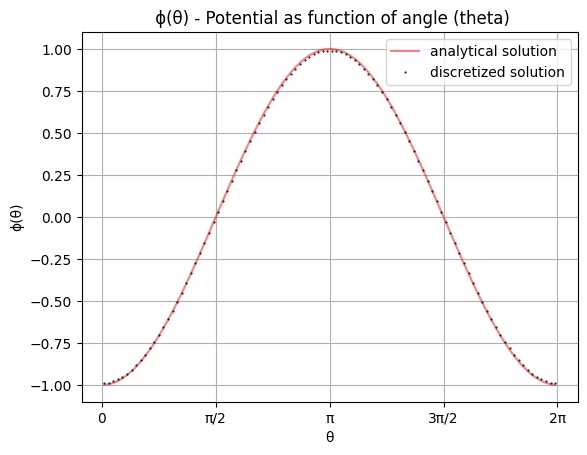

In [6]:
R0 = 1
number_of_elems = 100
pdcr, _ = circle_m_ij_coeficents(R0, number_of_elems)
plot_potential(number_of_elems, R0, pdcr)

In [7]:
def plot_accuracy(y_label_text, accuracy_list, resolution_list):
    plt.title('Added mass coefficent accuracy ratio as a function of the inverse of resolution', pad = 20)
    _ = plt.plot(resolution_list, accuracy_list,  '.r', markersize=10, label = 'analytical solution')
    plt.xlabel('1/N')
    plt.ylabel(y_label_text, rotation='horizontal', labelpad=50)
    plt.grid(True)

[3.14159265 3.14159265 0.        ]
[3.113037413897939, 3.1130374138979358, 7.388820195341261e-32]

[3.14159265 3.14159265 0.        ]
[3.1273171970590523, 3.1273171970590337, 1.4181478695004367e-31]

[3.14159265 3.14159265 0.        ]
[3.134455199029268, 3.1344551990292597, 2.7790249899988916e-31]



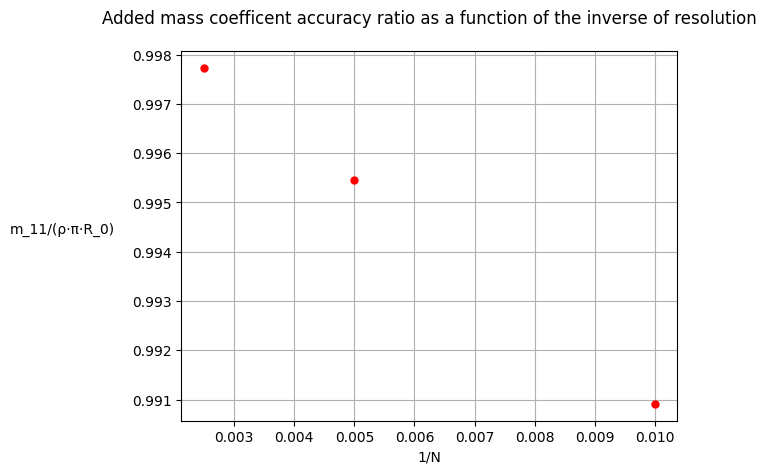

In [8]:
num_of_elems_list = np.array([100,200,400])
accuracy_matrix = np.empty((0, 2))
for n_elem in num_of_elems_list:
    pdcr, accuracy_list = circle_m_ij_coeficents(R0, n_elem)
    accuracy_matrix = np.vstack([accuracy_matrix, accuracy_list])
m11_accuracy = accuracy_matrix[:,0]
plot_accuracy('m_11/(ρ⋅π⋅R_0)', m11_accuracy, 1/num_of_elems_list)



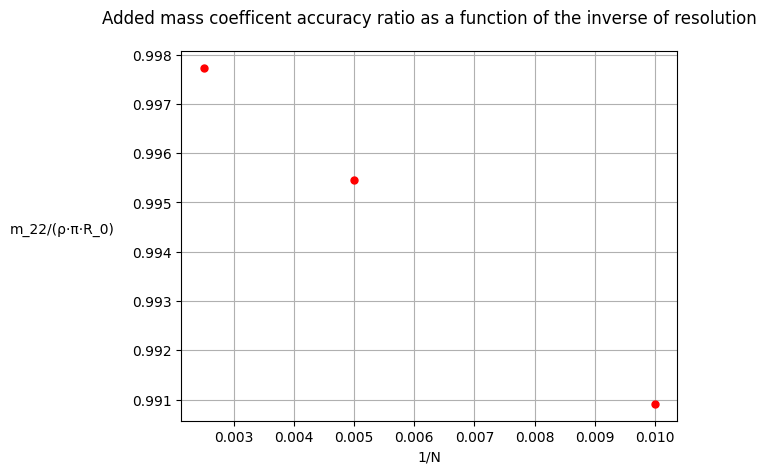

In [9]:
m22_accuracy = accuracy_matrix[:,1]
plot_accuracy('m_22/(ρ⋅π⋅R_0)', m22_accuracy, 1/num_of_elems_list)